In [1]:
import io

import matplotlib.pyplot as plt
import pandas as pd
import requests
import statsmodels.api as sm

%matplotlib inline

In [2]:
url = 'http://robjhyndman.com/tsdldata/data/nybirths.dat'
fopen = requests.get(url).content
ds = pd.read_csv(
    io.StringIO(fopen.decode('utf-8')), header=None, names=['birthcount'])
ds.head()

,birthcount
0,26.663
1,23.598
2,26.931
3,24.740
4,25.806


In [3]:
ds['date'] = pd.date_range('1946-01-01', '1959-12-31', freq='1M')
ds.set_index('date', inplace=True)
ds.head()

,birthcount
date,
1946-01-31,26.663
1946-02-28,23.598
1946-03-31,26.931
1946-04-30,24.740
1946-05-31,25.806


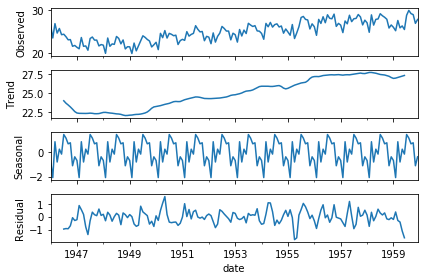

In [4]:
decomp = sm.tsa.seasonal_decompose(ds.birthcount, model='additive')
decomp.plot();

In [5]:
!ls ../../../data

IBM.csv
IBM_monthly.csv
KO.csv
MSFT.csv
Monthly_CO2_Concentrations.csv
Superstore.xls
^GSPC.csv
beer.csv
beerprod.dat
chemical-concentration-readings.csv
coloradoflow.dat
econmeasure_0.dat
econpredictor_1.dat
ffMonthly.pkl
inflation-consumer-prices-annual.csv
l8.1.x.dat
l8.1.y.dat
m-CAUS-7611.txt
m-GLBTs.txt
m-dec125.txt
m-dec125910-6111.txt
m-morgfed-7111.txt
m-ncdc-noaa-glbtemp.txt
m-unrate.txt
m-unrateic.txt
mean-daily-temperature-fisher-river.csv
or_monthly_mean_temp_1895-2019.csv
or_monthly_mean_temp_1895-2019.txt
q-gdp-ukcaus.txt
q-gdpunemp.txt
recruit.dat
soi.dat
sunspots.csv
us-airlines-monthly-aircraft-miles-flown.csv
us-airlines-monthly-aircraft-miles-flown.csv~
w-gasoline.txt
w-petroprice.txt
wisconsin-employment-time-series.csv


In [6]:
DATA = '../../../data'
ibm = pd.read_csv(f'{DATA}/IBM.csv')
ibm.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,84.5000,87.5000,84.1250,84.8125,56.790684,8007200
1,2001-01-03,83.7500,95.0000,83.7500,94.6250,63.361145,12769900
2,2001-01-04,94.7500,99.7500,92.6875,93.1875,62.398586,15420500
3,2001-01-05,93.9375,94.6875,91.0000,94.0000,62.942654,8043200
4,2001-01-08,93.5000,93.9375,91.5625,93.5625,62.649712,6064800


In [7]:
ibm = ibm[['Date', 'Adj Close']]
ibm.rename(columns={'Adj Close': 'close'}, inplace=True)
ibm.Date = pd.to_datetime(ibm.Date)
ibm.head()

,Date,close
0,2001-01-02,56.790684
1,2001-01-03,63.361145
2,2001-01-04,62.398586
3,2001-01-05,62.942654
4,2001-01-08,62.649712


# First-Order

In [8]:
def single_exp_smoothing(x, alpha):
    F = [x[0]]
    for t in range(1, len(x)):
        F.append(alpha * x[t] + (1 - alpha) * F[t - 1])
    return F

In [9]:
ibm['SES0'] = single_exp_smoothing(ibm.close, 0)
ibm['SES1'] = single_exp_smoothing(ibm.close, 1)

In [10]:
ibm['SES'] = single_exp_smoothing(ibm.close, 0.8)

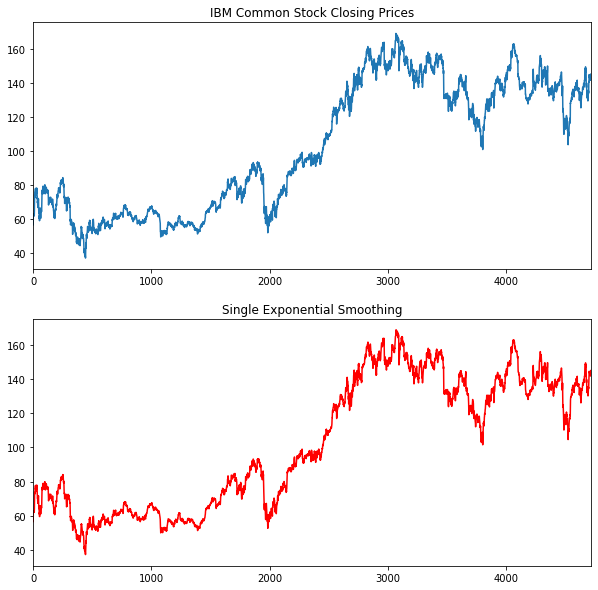

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1)
ibm.close.plot(ax=ax)
ax.set_title('IBM Common Stock Closing Prices')
ax = fig.add_subplot(2, 1, 2)
ibm.SES.plot(ax=ax, color='r')
ax.set_title('Single Exponential Smoothing');

In [13]:
# Calc single exp foreacast at dif vals
ibm['SES2'] = single_exp_smoothing(ibm.close, 0.2)
ibm['SES6'] = single_exp_smoothing(ibm.close, 0.6)
ibm['SES8'] = single_exp_smoothing(ibm.close, 0.8)

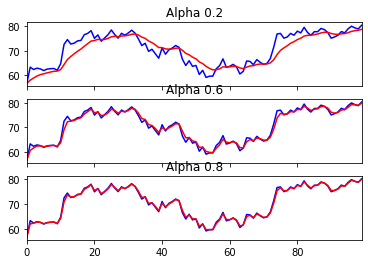

In [18]:
f, axarr = plt.subplots(3, sharex=True)
N = 100

ibm.close.iloc[:N].plot(color='b', ls='-', ax=axarr[0])
ibm.SES2.iloc[:N].plot(color='r', ls='-', ax=axarr[0])
axarr[0].set_title('Alpha 0.2')

ibm.close.iloc[:N].plot(color='b', ls='-', ax=axarr[1])
ibm.SES6.iloc[:N].plot(color='r', ls='-', ax=axarr[1])
axarr[1].set_title('Alpha 0.6')

ibm.close.iloc[:N].plot(color='b', ls='-', ax=axarr[2])
ibm.SES8.iloc[:N].plot(color='r', ls='-', ax=axarr[2])
axarr[2].set_title('Alpha 0.8');

# Second-Order

In [21]:
beer = pd.read_csv(f'{DATA}/beer.csv')
beer.rename(
    columns={
        'Quarterly beer production in Australia: megalitres. March 1956 '
        '? June 1994': 'beer'},
    inplace=True)
beer.head()

,Quarter,beer
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0
